In [14]:
import sys
import glob
import cv2
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
import requests
import json

%matplotlib inline

sys.path.append("../util")
from grape_detection_ import GrapeDetection

ModuleNotFoundError: No module named 'camera_thread'

## call API

In [2]:
def detect_via_api(api_url: str, image: list) -> dict[str, str]:
    try:
        _, image_bytes = cv2.imencode(".jpg", image)
        # PILLOW
        # image_bytes = BytesIO()
        # image.save(image_bytes, format="JPEG")
        
        files = {'image': ('image.jpg', image_bytes, 'image/jpeg')}

        # Make the POST request with the image file
        response = requests.post(api_url, files=files)

        # Check if the request was successful (status code 200)
        if response.status_code == 200:
            print("Image successfully posted to the API.")
            response_dict = json.loads(response.content.decode())
            return response_dict
        else:
            print(f"Error: {response.status_code} - {response.text}")
    except Exception as e:
        raise Exception

In [3]:
current = time.time()
api_url = "http://172.23.161.109:8300/detect_grape_bunch"
image_path = "./2024-03-30 19:02:08/draw/draw_0.jpg"
image = cv2.imread(image_path)
res = detect_via_api(api_url, image)
done = time.time()
# print(json.dump(res, indent=4))

Image successfully posted to the API.


In [4]:
for key, value in res.items():
    print(res[key])

[920.9965209960938, 126.04037475585938, 1251.523681640625, 704.2239990234375, 0.9084302186965942, 0.0]
[[976.0072631835938, 313.01806640625, 1062.6395263671875, 399.25274658203125, 0.9343026280403137, 1.0], [995.8968505859375, 196.3400421142578, 1082.5567626953125, 276.68707275390625, 0.9298126697540283, 1.0], [932.152099609375, 336.3681640625, 986.6943359375, 396.318603515625, 0.9270618557929993, 1.0], [1010.498779296875, 552.4190063476562, 1095.241943359375, 631.7210083007812, 0.9269839525222778, 1.0], [1076.8201904296875, 578.5625, 1142.2225341796875, 661.536865234375, 0.9226961135864258, 1.0], [1102.53662109375, 134.26193237304688, 1193.333251953125, 208.936767578125, 0.9187564849853516, 1.0], [930.3275756835938, 223.2620391845703, 998.7389526367188, 276.583251953125, 0.9137014746665955, 1.0], [1141.0281982421875, 575.4459228515625, 1217.3885498046875, 652.6588134765625, 0.9075152277946472, 1.0], [957.2902221679688, 523.7535400390625, 1038.9832763671875, 600.802490234375, 0.9053084

In [5]:
done - current

0.2402329444885254

## Single inference

In [2]:
import numpy as np

def resize_points(points, old_ranges, new_ranges):
    # Convert points to numpy array for easier manipulation
    points = np.array(points)
    
    # Initialize resized points array
    resized_points = np.zeros_like(points)
    
    # Resize each index of the points
    for i in range(len(points[0])):
        resized_points[:, i] = ((points[:, i] - old_ranges[i][0]) * (new_ranges[i][1] - new_ranges[i][0]) / (old_ranges[i][1] - old_ranges[i][0])) + new_ranges[i][0]
    
    return resized_points

# Example points
points = np.array([[1141.8, 1053.2, 1156, 1065.2],
                   [1114.8, 1084, 1127.5, 1096],
                   [1141, 1096.8, 1155.2, 1109.5],
                   [1123.8, 1096, 1135.8, 1111]])




In [3]:
grape_model_path = "../../berry_thinning/models/detection/yolov5s_2cls15_best.pt"
removal_model_path = "../../berry_thinning/models/removal/resnet18_bbox_aug_True_ratio1-8_bs-8_lr-0.001_epoch-3000 (1).pth"
grape_model = GrapeDetection(grape_model_path, removal_model_path)

Using cache found in /Users/kb/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-10-17 Python-3.9.18 torch-2.1.0 CPU

Fusing layers... 
Model summary: 224 layers, 7056607 parameters, 0 gradients
Adding AutoShape... 


In [4]:
image = cv2.imread('../test.jpg')
pred = grape_model.predict(image)

In [5]:
# bunch_xyxy = [int(point) for point in pred['bunch']]
bunch_x1, bunch_y1, bunch_x2, bunch_y2 = map(int, pred['bunch'])
removing_x1, removing_y1, removing_x2, removing_y2 = map(int, pred['remove'])

In [6]:
w, h, c = image.shape
w, h

(720, 1280)

In [7]:
np.array(pred['remove'], dtype=np.uint8)

array([140, 111, 196, 180], dtype=uint8)

In [11]:
# Define old and new ranges for each index
old_ranges = np.array([(0, h), (0, w), (0, h), (0, w)])
new_ranges = np.array([(900, h - 50), (300, w - 50),
              (900, h - 50), (300, w - 50)])

# removing_resize = resize_points(np.array(pred['remove'], dtype=np.uint8), old_ranges, new_ranges)
berry_boxes = resize_points(pred['berry'], old_ranges, new_ranges)

In [12]:
resized_array = ((pred['remove'] - old_ranges) * (new_ranges - new_ranges) / (old_ranges - old_ranges)) + new_ranges

ValueError: operands could not be broadcast together with shapes (4,) (4,2) 

In [304]:
removing_resize

NameError: name 'removing_resize' is not defined

In [302]:
pred['berry'][0: 4], berry_boxes[0: 4]

([[681.4130249023438, 256.2597961425781, 749.7171020507812, 315.1314392089844],
  [551.6181640625, 406.3829345703125, 612.7403564453125, 463.68377685546875],
  [680.2291259765625,
   465.07049560546875,
   747.3446044921875,
   529.7503051757812],
  [594.3108520507812, 462.7222900390625, 653.1218872070312, 533.052490234375]],
 array([[     1075.7,      431.69,      1093.3,      461.94],
        [     1042.2,      508.84,        1058,      538.28],
        [     1075.4,      538.99,      1092.7,      572.23],
        [     1053.2,      537.79,      1068.4,      573.93]]))

In [303]:
# Draw bunch line

cv2.line(image, (int((bunch_x1 + bunch_x2) // 2), bunch_y1), (int((bunch_x1 + bunch_x2) // 2), bunch_y2), (0, 255, 0), 20)

# for box in pred['berry']:
#     cv2.circle(image, (int((box[0] + box[2]) // 2), int((box[1] + box[3]) // 2)), 20, (255, 0, 0), -1)
# cv2.circle(image, (int((removing_x1 + removing_x2) // 2), int((removing_y1 + removing_y2) // 2)), 20, (0, 0, 255), -1)
    
for box in berry_boxes:
    cv2.circle(image, (int((box[0] + box[2]) // 2), int((box[1] + box[3]) // 2)), 10, (255, 0, 0), -1)

cv2.circle(image, (int((removing_resize[0] + removing_resize[2]) // 2), int((removing_resize[1] + removing_resize[3]) // 2)), 20, (0, 0, 255), -1)
    

NameError: name 'removing_resize' is not defined

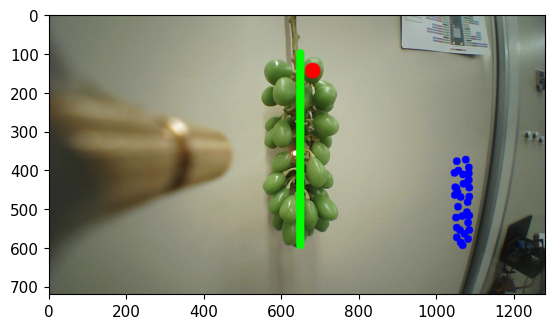

In [297]:
plt.imshow(image[:,:,::-1])

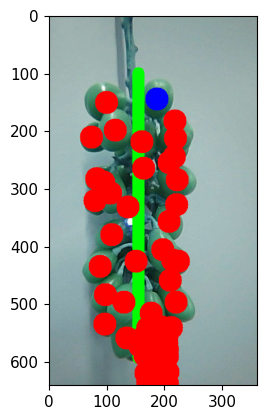

In [231]:
# plt.imshow(cv2.rectangle(image, (bunch_x1, bunch_y1), (bunch_x2, bunch_y2), (0, 255, 255), 2))
plt.imshow(image[bunch_y1 - 100: bunch_x1 + 100, bunch_y2 - 100: bunch_x2 + 100])
plt.show()

## Normalized removing position

In [2]:
draw_path = './2024-03-30 19:02:08/draw/*.jpg'
draw_imgs = sorted(glob.glob(draw_path))

frame_path = './2024-03-30 19:02:08/frame/*.jpg'
frame_imgs = sorted(glob.glob(frame_path))

In [3]:
draw_imgs[:4]

['./2024-03-30 19:02:08/draw/draw_0.jpg',
 './2024-03-30 19:02:08/draw/draw_1.jpg',
 './2024-03-30 19:02:08/draw/draw_10.jpg',
 './2024-03-30 19:02:08/draw/draw_100.jpg']

In [23]:
# Loop through each image and write to video

video_name = 'mygeneratedvideo.mp4'
img = cv2.imread(draw_path[0])
width, height, c = img.shape
codec = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter(video_name, codec, 1, (width, height))
for image_file in draw_path:
    img = cv2.imread(image_file)
    video.write(img[:,:,::-1])

# Release VideoWriter
video.release()

In [6]:
len(frame_imgs) / 4

360.0

In [6]:
from matplotlib import pyplot as plt
grape_model_path = "../../berry_thinning/models/detection/yolov5s_2cls15_best.pt"
removal_model_path = "../../berry_thinning/models/removal/resnet18_bbox_aug_True_ratio1-8_bs-8_lr-0.001_epoch-3000 (1).pth"
grape_model = GrapeDetection(grape_model_path, removal_model_path)

Using cache found in /Users/kb/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-10-17 Python-3.9.18 torch-2.1.0 CPU

Fusing layers... 
Model summary: 224 layers, 7056607 parameters, 0 gradients
Adding AutoShape... 


In [7]:
pred = grape_model.predict(image)

In [8]:
pred

{'bunch': [918.1256713867188,
  122.20941162109375,
  1249.34375,
  700.3757934570312],
 'berry': [[1010.886474609375,
   552.34326171875,
   1094.51171875,
   632.17236328125],
  [977.7412109375, 312.6246032714844, 1063.2608642578125, 400.2299499511719],
  [1075.7705078125, 577.4786376953125, 1142.7744140625, 662.7735595703125],
  [997.5972290039062,
   196.33737182617188,
   1081.9468994140625,
   277.1211242675781],
  [957.4168090820312,
   523.2007446289062,
   1039.4705810546875,
   602.6251831054688],
  [931.064453125, 222.448974609375, 998.84619140625, 276.29937744140625],
  [1141.7861328125, 575.7413940429688, 1217.397705078125, 652.6337280273438],
  [1103.072998046875, 135.333984375, 1192.59033203125, 208.28811645507812],
  [953.1978149414062, 585.84765625, 1015.0801391601562, 644.8126220703125],
  [932.1800537109375, 336.6981506347656, 986.39306640625, 396.9007263183594],
  [933.4200439453125, 471.7021789550781, 1026.46728515625, 537.3306274414062],
  [1008.9638061523438, 620

In [118]:
grape_detection_model = torch.hub.load('ultralytics/yolov5', 'custom', grape_model_path)

Using cache found in /Users/kb/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-10-17 Python-3.9.18 torch-2.1.0 CPU

Fusing layers... 
Model summary: 224 layers, 7056607 parameters, 0 gradients
Adding AutoShape... 


In [119]:
batch = [cv2.imread(frame_imgs[idx])[:,:,::-1] for idx in range(0, len(frame_imgs), len(frame_imgs)//30)]

In [122]:
batch = torch.tensor(batch)

torch.Size([30, 720, 1280, 3])

In [124]:
pred = grape_detection_model(batch)

In [132]:
len(pred.xyxy)

30

In [5]:
predictions = {}
for indx in range(0, len(frame_imgs), len(frame_imgs)//30):
    img = cv2.imread(frame_imgs[indx])[:,:,::-1]
    pred = grape_model.predict(img)
    predictions[frame_imgs[indx]] = pred

In [6]:
for key, value in predictions.items():
    print(key)

./2024-03-30 19:02:08/frame/frame_0.jpg
./2024-03-30 19:02:08/frame/frame_1040.jpg
./2024-03-30 19:02:08/frame/frame_1084.jpg
./2024-03-30 19:02:08/frame/frame_1127.jpg
./2024-03-30 19:02:08/frame/frame_1170.jpg
./2024-03-30 19:02:08/frame/frame_1213.jpg
./2024-03-30 19:02:08/frame/frame_1257.jpg
./2024-03-30 19:02:08/frame/frame_130.jpg
./2024-03-30 19:02:08/frame/frame_1343.jpg
./2024-03-30 19:02:08/frame/frame_1387.jpg
./2024-03-30 19:02:08/frame/frame_143.jpg
./2024-03-30 19:02:08/frame/frame_178.jpg
./2024-03-30 19:02:08/frame/frame_220.jpg
./2024-03-30 19:02:08/frame/frame_264.jpg
./2024-03-30 19:02:08/frame/frame_307.jpg
./2024-03-30 19:02:08/frame/frame_350.jpg
./2024-03-30 19:02:08/frame/frame_394.jpg
./2024-03-30 19:02:08/frame/frame_437.jpg
./2024-03-30 19:02:08/frame/frame_480.jpg
./2024-03-30 19:02:08/frame/frame_523.jpg
./2024-03-30 19:02:08/frame/frame_567.jpg
./2024-03-30 19:02:08/frame/frame_61.jpg
./2024-03-30 19:02:08/frame/frame_653.jpg
./2024-03-30 19:02:08/frame/f

In [7]:
from PIL import Image
first_key = next(iter(predictions))
image = cv2.imread(first_key)
# image = cv2.imread(first_key)[:,:,::-1]
# image = Image.open(first_key)
first_key

'./2024-03-30 19:02:08/frame/frame_0.jpg'

In [40]:
bunch_xyxy = list(map(int, predictions[first_key]['bunch'][0]))
remove_xyxy = list(map(int, predictions[first_key]['remove']))
remove_center = (int(remove_xyxy[0] + remove_xyxy[2]) // 2, int(remove_xyxy[1] + remove_xyxy[3]) // 2)
bunch_xyxy, remove_xyxy, remove_center

([921, 124, 1251, 704], [975, 312, 1062, 399], (1018, 355))

In [41]:
min_y = bunch_xyxy[1] 
max_y = bunch_xyxy[3]
min_x = bunch_xyxy[0] 
max_x = bunch_xyxy[2]

In [42]:
x_prime = (remove_center[0] - min_x) / (max_x - min_x)
y_prime = (remove_center[1] - min_y) / (max_y - min_y)
x_prime, y_prime

(0.29393939393939394, 0.39827586206896554)

In [43]:
x_coor = int(((max_x - min_x) * x_prime) + min_x)
y_coor = int(((max_y - min_y) * y_prime) + min_y)
x_coor, y_coor

(1018, 355)

In [61]:
x = [[773, 222], [773, 222], [600, 222]]

In [62]:
x[-1]

[600, 222]

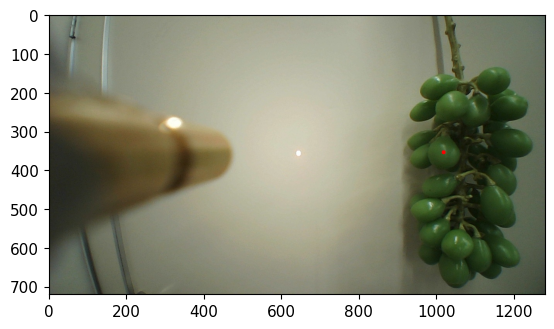

In [35]:
# plt.imshow(cv2.rectangle(image, (bunch_xyxy[0], bunch_xyxy[1]), (bunch_xyxy[2], bunch_xyxy[3]), (0, 255, 255), 2)[:,:,::-1])
plt.imshow(cv2.circle(image, remove_center, 5, (0, 0, 255), -1)[:,:,::-1])

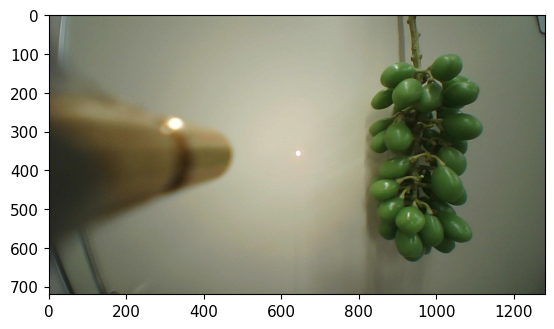

In [54]:
second_key = './2024-03-30 19:02:08/frame/frame_350.jpg'
image2 = cv2.imread(second_key)
plt.imshow(image2[:,:,::-1])

In [55]:
bunch_xyxy = list(map(int, predictions[second_key]['bunch'][0]))
remove_xyxy = list(map(int, predictions[second_key]['remove']))
remove_center = (int(remove_xyxy[0] + remove_xyxy[2]) // 2, int(remove_xyxy[1] + remove_xyxy[3]) // 2)

In [56]:
bunch_xyxy

[819, 89, 1118, 635]

In [57]:
# ((bunch_x2 - bunch_x1) * x_prime) + bunch_x1
x1, y1, x2, y2 = map(int, bunch_xyxy)
x_coor = ((x2 - x1) * x_prime) + x1
y_coor = ((y2 - y1) * y_prime) + y1
x_coor, y_coor

(906.8878787878788, 306.45862068965516)

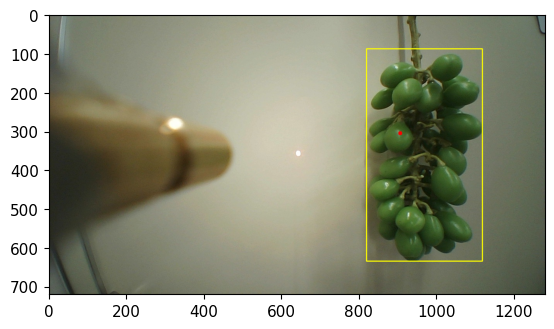

In [58]:
plt.imshow(cv2.rectangle(image2, (bunch_xyxy[0], bunch_xyxy[1]), (bunch_xyxy[2], bunch_xyxy[3]), (0, 255, 255), 2)[:,:,::-1])
plt.imshow(cv2.circle(image2, (int(x_coor), int(y_coor)), 5, (0, 0, 255), -1)[:,:,::-1])

## Draw 3-axis with opencv

In [92]:
# Define dimensions of the RGB array
height = 720  # Height of the image
width = 1280   # Width of the image

# Generate random values for the RGB channels
red_channel = np.random.randint(0, 1, size=(height, width), dtype=np.uint8)
green_channel = np.random.randint(0, 1, size=(height, width), dtype=np.uint8)
blue_channel = np.random.randint(0, 1, size=(height, width), dtype=np.uint8)

# Combine the channels into an RGB array
rgb_array = np.stack([red_channel, green_channel, blue_channel], axis=-1)

print(rgb_array.shape)

(720, 1280, 3)


In [93]:
(text_width, text_height), _ = cv2.getTextSize('X', cv2.FONT_HERSHEY_SIMPLEX, 1, 1)

In [94]:
text_width, text_height

(21, 22)

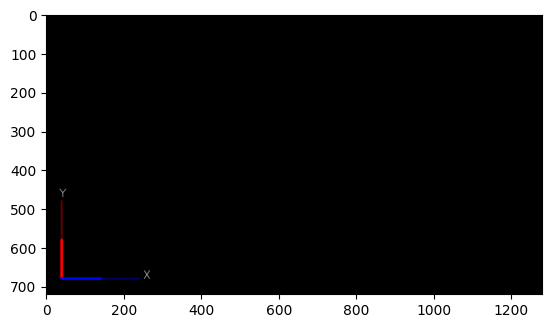

In [95]:
# BASE: draw Y-axis line
rgb_array = cv2.line(rgb_array, (40, height - 40), (40, height - 240), (100, 0, 0), 3)
# VALUE: draw Y-axis line
rgb_array = cv2.line(rgb_array, (40, height - 40), (40, height - 140), (255, 0, 0), 6)
# LABEL                    Axis label position = x_coor - (text_width // 2)
rbg_array = cv2.putText(rgb_array, 'Y', (34, height - 250), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 1, cv2.LINE_AA)

# BASE: draw X-axis line
rgb_array = cv2.line(rgb_array, (40, height - 40), (240, height - 40), (0, 0, 100), 3)
# VALUE: draw X-axis line
rgb_array = cv2.line(rgb_array, (40, height - 40), (140, height - 40), (0, 0, 255), 6)
# LABEL                    Axis label position = x_coor - (text_width // 2)
rbg_array = cv2.putText(rgb_array, 'X', (250, height - 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 1, cv2.LINE_AA)
plt.imshow(rgb_array)

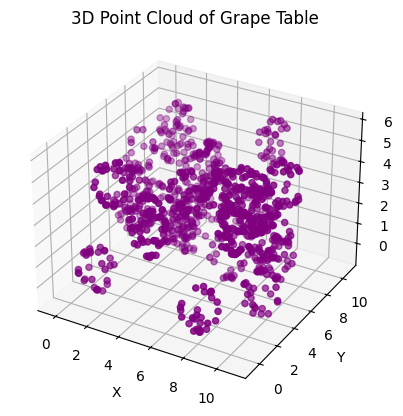

In [100]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def generate_berry_cloud(num_points_per_berry=30, radius=1):
    """Generate a cloud of points around a spherical berry shape."""
    theta = np.random.uniform(0, np.pi, num_points_per_berry)
    phi = np.random.uniform(0, 2 * np.pi, num_points_per_berry)
    x = radius * np.sin(theta) * np.cos(phi)
    y = radius * np.sin(theta) * np.sin(phi)
    z = radius * np.cos(theta)
    return np.vstack((x, y, z)).T

def generate_grape_table(num_berries=35, table_size=(10, 10, 5)):
    """Generate a 3D point cloud representing a grape table."""
    grape_table = []
    for _ in range(num_berries):
        berry_position = np.random.uniform(low=(0, 0, 0), high=table_size, size=(1, 3))
        berry_cloud = generate_berry_cloud() + berry_position
        grape_table.extend(berry_cloud)
    return np.array(grape_table)

# Generate grape table
grape_table = generate_grape_table()

# Plot the grape table
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(grape_table[:, 0], grape_table[:, 1], grape_table[:, 2], c='purple', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Point Cloud of Grape Table')
plt.show()


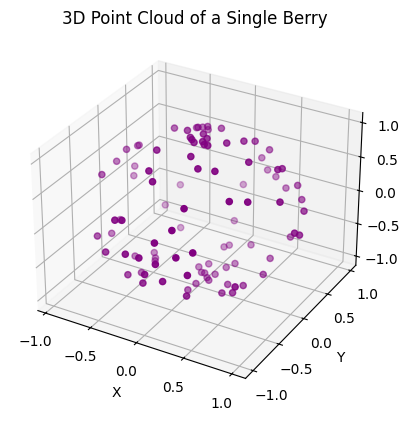

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def generate_berry_cloud(num_points_per_berry=100, radius=1):
    """Generate a cloud of points around a spherical berry shape."""
    theta = np.random.uniform(0, np.pi, num_points_per_berry)
    phi = np.random.uniform(0, 2 * np.pi, num_points_per_berry)
    x = radius * np.sin(theta) * np.cos(phi)
    y = radius * np.sin(theta) * np.sin(phi)
    z = radius * np.cos(theta)
    return np.vstack((x, y, z)).T

# Generate a single berry cloud
berry_cloud = generate_berry_cloud()

# Plot the single berry cloud
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(berry_cloud[:, 0], berry_cloud[:, 1], berry_cloud[:, 2], c='purple', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Point Cloud of a Single Berry')
plt.show()